
### Import libraries

---



In [1]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import string

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [3]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Generating Geometric Brownian motion

---

In [4]:
class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    close price based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion for pricing

    For now the tool is hardcoded to generate business day daily
    data between two dates, inclusive.

    Note that the pricing data is completely uncorrelated,
    which is not likely to be the case in real asset paths.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    """

    def __init__(
        self,
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma

    def _generate_random_symbol(self):
        """
        Generates a random ticker symbol string composed of
        uppercase ASCII characters

        Returns
        -------
        `str`
            The random ticker string composed of uppercase letters.
        """
        return ''.join(
            random.choices(
                string.ascii_uppercase,
                k=4
            )
        )

    def _create_empty_frame(self,symbol):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price
        columns are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty  DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        zeros = pd.Series(np.zeros(len(date_range)))

        return pd.DataFrame(
            {
                'date': date_range,
                symbol: zeros
            }
        )[['date', symbol]]

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates an asset price path using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `np.ndarray`
            The asset price path 
        """
        n = len(data)
        T = n / 252.0  # Business days in a year
        dt = T / n 
        
        # Vectorised implementation of asset path generation
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size= n )
        )
        
        return self.init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path,symbol):
        """

        Parameters
        ----------
        data : `pd.DataFrame`
            The price/volume DataFrame to modify in place.
        path : `np.ndarray`
            The original NumPy array of the asset price path.
        """
        data[symbol] = path


    def __call__(self):
        """
        The entrypoint for generating the asset  frame. Firstly this
        generates a symbol and an empty frame. It then populates this
        frame with some simulated GBM data.
        """
        symbol = self._generate_random_symbol()
        data = self._create_empty_frame()
        path = self._create_geometric_brownian_motion(data)
        self._append_path_to_data(data, path)


def gen(random_seed, start_date, end_date, init_price, mu, sigma):
    random_seed = int(random_seed)
    init_price = float(init_price)
    mu = float(mu)
    sigma = float(sigma)

    # Need to seed both Python and NumPy separately
    random.seed(random_seed)
    np.random.seed(seed=random_seed)

    gbmas = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    )
    return gbmas
     

In [5]:
start_data = "2017-01-01"
end_data = "2022-12-31"

In [6]:
df = []
for i in range(0,10):
  stock = gen(i, start_data, end_data,100,0.1,0.2)

  symbol = stock._generate_random_symbol()        
  data = stock._create_empty_frame(symbol)
  path = stock._create_geometric_brownian_motion(data)
  stock._append_path_to_data(data, path,symbol)

  if i == 0:
    df = data.copy()
  else:
    df = pd.concat([df,data[symbol]], axis = 1)

df = df.set_index("date")

In [7]:
display(df)

,VTKG,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,,
2017-01-02,102.279843,102.099974,99.507895,102.311517,100.095493,100.589370,99.639587,102.185140,100.146761,100.033148
2017-01-03,102.829429,101.348242,99.468952,102.908394,100.759946,100.202734,100.590879,101.619299,101.565412,99.700547
2017-01-04,104.138317,100.708041,96.858338,103.066296,99.535176,103.351704,100.899335,101.693605,99.135836,98.339670
2017-01-05,107.154321,99.387363,98.912182,100.706675,100.440658,103.056685,99.794523,102.249521,97.450259,98.354929
2017-01-06,109.740285,100.508826,96.733009,100.387208,99.944441,103.231867,96.747091,101.270390,94.701181,97.918276
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,118.253672,409.506673,62.465585,123.907478,309.864934,251.497558,175.216423,97.153936,426.964560,198.490468
2022-12-27,117.336427,416.939245,61.453604,125.391893,310.478921,251.547898,172.461570,97.638068,420.536009,197.122543
2022-12-28,115.709274,419.380784,61.257502,124.465044,310.604221,255.211306,175.626566,96.002537,422.663860,201.764408


In [8]:
n = random.randint(0,10)

X_train = df.iloc[:-5,:].copy()
X_train.drop(X_train.columns[n], axis=1, inplace = True)
y_train = df.iloc[:-5,n].copy()

X_test = df.iloc[-5:,:].copy()
X_test.drop(X_test.columns[n], axis=1, inplace = True)
y_test = df.iloc[-5:,n].copy()


 **Train**

In [9]:
print("---X_train----")
display(X_train)
print("\n--y_train----")
display(y_train)

---X_train----


,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,
2017-01-02,102.099974,99.507895,102.311517,100.095493,100.589370,99.639587,102.185140,100.146761,100.033148
2017-01-03,101.348242,99.468952,102.908394,100.759946,100.202734,100.590879,101.619299,101.565412,99.700547
2017-01-04,100.708041,96.858338,103.066296,99.535176,103.351704,100.899335,101.693605,99.135836,98.339670
2017-01-05,99.387363,98.912182,100.706675,100.440658,103.056685,99.794523,102.249521,97.450259,98.354929
2017-01-06,100.508826,96.733009,100.387208,99.944441,103.231867,96.747091,101.270390,94.701181,97.918276
...,...,...,...,...,...,...,...,...,...
2022-12-19,394.910406,66.556533,119.689445,315.669245,247.038224,176.861500,99.976327,443.800379,200.628202
2022-12-20,394.255503,66.446479,120.730958,314.981876,244.787916,178.802789,100.330481,440.189436,193.802824
2022-12-21,399.868455,66.114978,123.506984,313.768630,244.373693,175.327846,99.668421,429.644234,198.567541



--y_train----


date
2017-01-02    102.279843
2017-01-03    102.829429
2017-01-04    104.138317
2017-01-05    107.154321
2017-01-06    109.740285
                 ...    
2022-12-19    116.129516
2022-12-20    116.078188
2022-12-21    116.522565
2022-12-22    115.619193
2022-12-23    115.874847
Name: VTKG, Length: 1560, dtype: float64

 **Test**

In [10]:
print("---X_test----")
display(X_test)
print("\n--y_test----")
display(y_test)

---X_test----


,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,
2022-12-26,409.506673,62.465585,123.907478,309.864934,251.497558,175.216423,97.153936,426.964560,198.490468
2022-12-27,416.939245,61.453604,125.391893,310.478921,251.547898,172.461570,97.638068,420.536009,197.122543
2022-12-28,419.380784,61.257502,124.465044,310.604221,255.211306,175.626566,96.002537,422.663860,201.764408
2022-12-29,417.294179,60.757400,124.237516,318.523192,250.791698,175.343510,98.653878,429.754767,201.659396
2022-12-30,422.775341,60.583527,124.476520,323.452046,245.967662,177.901520,98.822888,430.773990,201.048648



--y_test----


date
2022-12-26    118.253672
2022-12-27    117.336427
2022-12-28    115.709274
2022-12-29    117.208715
2022-12-30    117.026385
Name: VTKG, dtype: float64

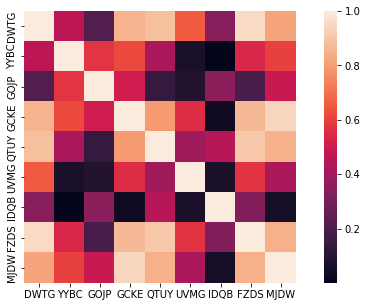

In [11]:
corr_mat = np.abs(X_train.corr())
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_mat,square = True, ax = ax)

In [12]:
period = [1,3,5,10]
col = X_train.columns
for j in col:
  for i in period:
    X_train[f"pct_{j}_{i}"] = X_train[j].pct_change(i)
    X_train[f"pct_{j}_{i}"] = X_train[f"pct_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

    X_train[f"Volatility_{j}_{i}"] = np.log(X_train[j]).diff().rolling(i).std()
    X_train[f"Volatility_{j}_{i}"] = X_train[f"Volatility_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

In [13]:
X_train

,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW,pct_DWTG_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,102.099974,99.507895,102.311517,100.095493,100.589370,99.639587,102.185140,100.146761,100.033148,-0.026568,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-03,101.348242,99.468952,102.908394,100.759946,100.202734,100.590879,101.619299,101.565412,99.700547,-0.026568,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-04,100.708041,96.858338,103.066296,99.535176,103.351704,100.899335,101.693605,99.135836,98.339670,-0.026568,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-05,99.387363,98.912182,100.706675,100.440658,103.056685,99.794523,102.249521,97.450259,98.354929,-0.026568,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-06,100.508826,96.733009,100.387208,99.944441,103.231867,96.747091,101.270390,94.701181,97.918276,-0.008282,...,0.038181,0.017297,-0.017876,0.007080,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,394.910406,66.556533,119.689445,315.669245,247.038224,176.861500,99.976327,443.800379,200.628202,0.004444,...,0.012039,0.010789,0.003902,0.014260,-0.004312,0.011628,-0.014439,0.011383,-0.048949,0.013108
2022-12-20,394.255503,66.446479,120.730958,314.981876,244.787916,178.802789,100.330481,440.189436,193.802824,-0.007397,...,0.004933,0.010953,-0.042614,0.020161,-0.027405,0.019130,-0.031672,0.014883,-0.094235,0.014295
2022-12-21,399.868455,66.114978,123.506984,313.768630,244.373693,175.327846,99.668421,429.644234,198.567541,0.010472,...,-0.017799,0.012189,-0.004604,0.030112,-0.006409,0.023406,0.004519,0.016770,-0.061966,0.015546


In [14]:
X_train.drop(col, axis = 1, inplace = True)

In [15]:
X_train

,pct_DWTG_3,Volatility_DWTG_3,pct_DWTG_5,Volatility_DWTG_5,pct_DWTG_10,Volatility_DWTG_10,pct_DWTG_21,Volatility_DWTG_21,pct_YYBC_3,Volatility_YYBC_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,-0.026568,0.003697,-0.043415,0.014347,-0.011047,0.015514,-0.045767,0.013677,-0.005987,0.023830,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-03,-0.026568,0.003697,-0.043415,0.014347,-0.011047,0.015514,-0.045767,0.013677,-0.005987,0.023830,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-04,-0.026568,0.003697,-0.043415,0.014347,-0.011047,0.015514,-0.045767,0.013677,-0.005987,0.023830,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-05,-0.026568,0.003697,-0.043415,0.014347,-0.011047,0.015514,-0.045767,0.013677,-0.005987,0.023830,...,0.038181,0.017297,-0.016777,0.007231,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
2017-01-06,-0.008282,0.012595,-0.043415,0.014347,-0.011047,0.015514,-0.045767,0.013677,-0.027505,0.026312,...,0.038181,0.017297,-0.017876,0.007080,-0.026748,0.005142,-0.052578,0.007358,0.045054,0.011679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,0.004444,0.007597,-0.014228,0.008015,-0.038271,0.009269,-0.012589,0.011220,-0.013518,0.014985,...,0.012039,0.010789,0.003902,0.014260,-0.004312,0.011628,-0.014439,0.011383,-0.048949,0.013108
2022-12-20,-0.007397,0.001084,-0.006683,0.007169,-0.040300,0.009183,-0.016430,0.011203,-0.007253,0.014700,...,0.004933,0.010953,-0.042614,0.020161,-0.027405,0.019130,-0.031672,0.014883,-0.094235,0.014295
2022-12-21,0.010472,0.009237,0.017054,0.008176,-0.033594,0.010326,-0.008962,0.011567,-0.023864,0.008350,...,-0.017799,0.012189,-0.004604,0.030112,-0.006409,0.023406,0.004519,0.016770,-0.061966,0.015546


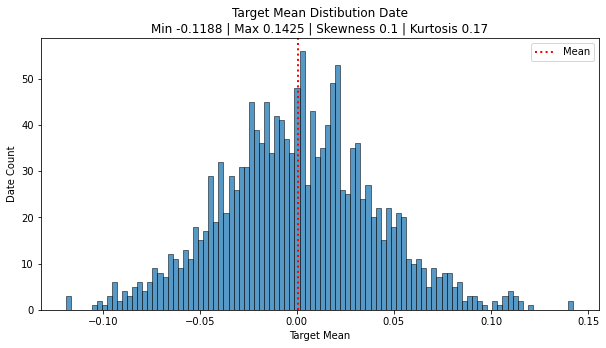

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=X_train["pct_IDQB_10"].values, bins=100,
             ax=ax)
ax.axvline(x=X_train["pct_IDQB_10"].mean(), color='red', linestyle='dotted', linewidth=2, 
           label='Mean')

ax.set_title("Target Mean Distibution Date\n"
             f"""Min {round(X_train["pct_IDQB_10"].min(), 4)} | """
             f"""Max {round(X_train["pct_IDQB_10"].max(), 4)} | """
             f"""Skewness {round(X_train["pct_IDQB_10"].skew(), 2)} | """
             f"""Kurtosis {round(X_train["pct_IDQB_10"].kurtosis(), 2)}""")

ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()


## Model selection

---

- K-Nearest Neighbour Regressor
- Decision tree
- Random Forest


In [17]:
mae_dict = {"KNN":[],"Decision_Tree":[],"Random_Forest":[]}

**K-Nearest Neighbour Regressor**





In [18]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
mae_ls = []

In [19]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    n_neighbors = 3
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
    knn_reg.fit(X_train_cross, y_train_cross)
    y_pred = knn_reg.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["KNN"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 17.33

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 32.23

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 36.5

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 18.82

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 21.42

Mean MAE 25.26
CPU t

**Decision Tree** 



In [20]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
mae_ls = []

In [21]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(X_train_cross, y_train_cross)
    y_pred = tree_reg.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["Decision_Tree"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 17.09

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 33.16

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 35.24

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 21.91

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 21.05

Mean MAE 25.69
CPU 

**Random Forest**

In [22]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
feat_importance_forest = pd.DataFrame()
mae_ls = []

In [23]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    regr = RandomForestRegressor()
    regr.fit(X_train_cross, y_train_cross)
    y_pred = regr.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["Random_Forest"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 13.18

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 34.23

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 33.41

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 11.95

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 14.17

Mean MAE 21.39
CPU 

**Selecting the best model**

In [24]:
print(mae_dict)

{'KNN': [25.26], 'Decision_Tree': [25.69], 'Random_Forest': [21.39]}


Since Random Forest model provides a better MAE, it will be used to build the final model

## Hyperparameter tuning
---

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              # 'min_samples_split': min_samples_split,
              # 'min_samples_leaf': min_samples_leaf,
              # 'bootstrap': bootstrap
               }

In [ ]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
regr_final = RandomForestRegressor()

gsearch = GridSearchCV(estimator=regr_final, cv=ts_fold,
                       scoring = 'neg_mean_absolute_percentage_error',
                      param_grid=random_grid)
gsearch.fit(X_train, y_train)
results = gsearch.cv_results_

In [ ]:
results

## Final Model

-----


In [ ]:
final_model = gsearch.best_estimator_
final_model.fit(X_train, y_train)

In [ ]:
period = [1,3,5,10]
col = X_test.columns
for j in col:
  for i in period:
    X_test[f"pct_{j}_{i}"] = X_test[j].pct_change(i)
    X_test[f"pct_{j}_{i}"] = X_test[f"pct_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

    X_test[f"Volatility_{j}_{i}"] = np.log(X_test[j]).diff().rolling(i).std()
    X_test[f"Volatility_{j}_{i}"] = X_test[f"Volatility_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

In [ ]:
y_final_pred = regr.predict(X_test)
final_mae = mean_absolute_error(y_test, y_final_pred)

In [ ]:
final_mae

## Literature

----

https://www.quantstart.com/articles/geometric-brownian-motion-simulation-with-python/


https://github.com/GariZabaleta/jpx-tokyo-stock-exchange-prediction/blob/master/jpx-prediction.ipynb